#load depenedencies and dataset


In [1]:
!pip install camel-tools

In [2]:
!pip install --upgrade --force-reinstall farasapy

  Using cached farasapy-0.0.14-py3-none-any.whl.metadata (8.9 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached charset_normalizer-3.4.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (35 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.4.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached certifi-2025.4.26-py3-none-any.whl.metadata (2.5 kB)
Using cached farasapy-0.0.14-py3-none-any.whl (11 kB)
Using cached requests-2.32.3-py3-none-any.whl (64 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached certifi-2025.4.26-py3-none-any.whl (159 kB)
Using cached charset_normalizer-3.4.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (143 kB)
Using cached idna-3.10-py3-none-any.whl (70 kB)
Using cached urllib3-2.4.0-py3-none-any.whl (128 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.4.0

In [2]:
import pandas as pd

train_df = pd.read_csv("/content/train-data-final.csv")
test_df  = pd.read_csv("/content/testing-data-final.csv")


#data  analysis and visualization

In [3]:
# See how many samples
print(f"Training samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")

Training samples: 12549
Testing samples: 3000


In [4]:
# Check for missing values
print(train_df.isnull().sum())
print(test_df.isnull().sum())

tweet        1
sarcasm      1
sentiment    1
dialect      1
dtype: int64
tweet        0
sarcasm      0
sentiment    0
dialect      0
dtype: int64


In [5]:
# See label distributions
print(train_df['sarcasm'].value_counts())
print(train_df['sentiment'].value_counts())
print(train_df['dialect'].value_counts())

sarcasm
False    10380
True      2168
Name: count, dtype: int64
sentiment
NEU    5747
NEG    4621
POS    2180
Name: count, dtype: int64
dialect
msa       8562
egypt     2675
gulf       644
levant     624
magreb      43
Name: count, dtype: int64


In [6]:
# See one example
train_df.sample(5)

print("Columns:   ", train_df.columns.tolist())

Columns:    ['tweet', 'sarcasm', 'sentiment', 'dialect']


In [7]:
train_df.head(5)
test_df.head(5)


,tweet,sarcasm,sentiment,dialect
0,اخوي حانق يالغلا وشفيك معصب؟ عادي تراهم بشر يف...,False,NEG,msa
1,اف مو متعوده عليهم سته,True,NEG,msa
2,اللهم اشفِ مرضانا ومرضى المسلمين,False,POS,msa
3,ابشركم طلقت السات,False,POS,gulf
4,مؤشر خطير ٩٠٪ من الشخصيات البرلمانية في الكويت...,True,NEG,msa


In [8]:
print("Train missing values:\n", train_df.isnull().sum())
print("Test missing values:\n",  test_df.isnull().sum())


Train missing values:
 tweet        1
sarcasm      1
sentiment    1
dialect      1
dtype: int64
Test missing values:
 tweet        0
sarcasm      0
sentiment    0
dialect      0
dtype: int64


In [9]:
for col in ["sarcasm", "sentiment", "dialect"]:
    print(f"\nTrain {col} distribution:")
    print(train_df[col].value_counts(normalize=True))



Train sarcasm distribution:
sarcasm
False    0.827223
True     0.172777
Name: proportion, dtype: float64

Train sentiment distribution:
sentiment
NEU    0.458001
NEG    0.368266
POS    0.173733
Name: proportion, dtype: float64

Train dialect distribution:
dialect
msa       0.682340
egypt     0.213181
gulf      0.051323
levant    0.049729
magreb    0.003427
Name: proportion, dtype: float64


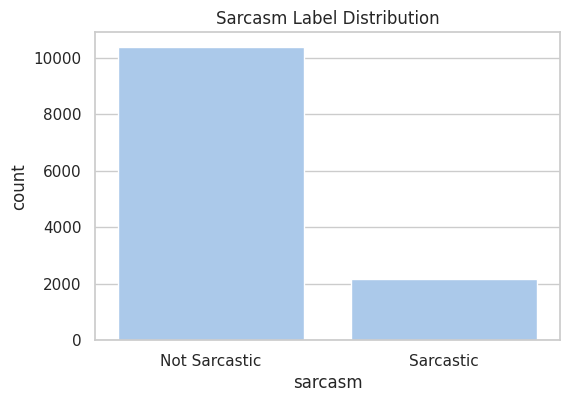

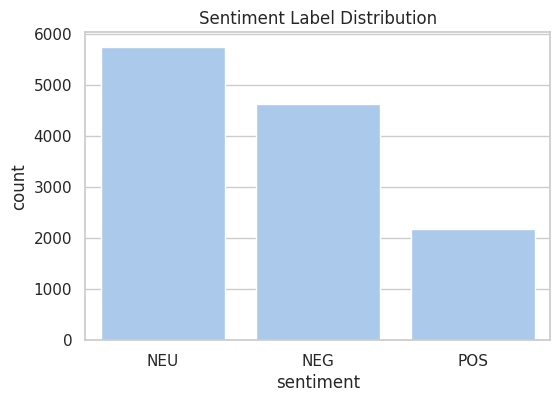

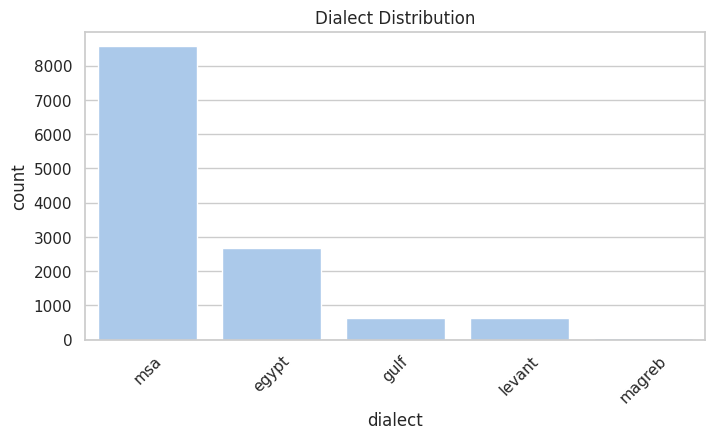

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style
sns.set(style="whitegrid", palette="pastel")

# 1. Sarcasm distribution
plt.figure(figsize=(6,4))
sns.countplot(x='sarcasm', data=train_df)
plt.title('Sarcasm Label Distribution')
plt.xticks([0,1], ['Not Sarcastic', 'Sarcastic'])
plt.show()

# 2. Sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=train_df, order=train_df['sentiment'].value_counts().index)
plt.title('Sentiment Label Distribution')
plt.show()

# 3. Dialect distribution
plt.figure(figsize=(8,4))
sns.countplot(x='dialect', data=train_df, order=train_df['dialect'].value_counts().index)
plt.title('Dialect Distribution')
plt.xticks(rotation=45)
plt.show()


#data preprocessing

In [11]:
from camel_tools.utils.dediac import dediac_ar
from camel_tools.utils.normalize import normalize_alef_maksura_ar, normalize_teh_marbuta_ar, normalize_alef_ar
import re

def advanced_arabic_cleaner(text):
    if not isinstance(text, str):
        return ""  # if text is NaN or not string, return empty string

    # 1. Remove diacritics
    text = dediac_ar(text)

    # 2. Normalize Arabic letters
    text = normalize_alef_maksura_ar(text)  # ى -> ي
    text = normalize_alef_ar(text)          # آ, أ, إ -> ا
    text = normalize_teh_marbuta_ar(text)   # ة -> ه
    # Remove diacritics

    text = dediac_ar(text)
    # 3. Remove URLs
    text = re.sub(r"http\S+|www.\S+", "", text)

    # 4. Remove mentions (@username)
    text = re.sub(r"@\S+", "", text)

    # 5. Remove hashtags (#hashtag)
    text = re.sub(r"#\S+", "", text)

    # 6. Keep only Arabic letters and spaces
    text = re.sub(r'[^\u0600-\u06FF\s]', '', text)

    # 7. Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()


    return text



In [12]:
train_df['clean_text'] = train_df['tweet'].apply(advanced_arabic_cleaner)
test_df['clean_text'] = test_df['tweet'].apply(advanced_arabic_cleaner)

# Quick look
train_df[['tweet', 'clean_text']].sample(5)


,tweet,clean_text
205,اليمنية مجلس الوزراء السعودي ضرورة وضع حد للم...,اليمنيه مجلس الوزراء السعودي ضروره وضع حد للمم...
4083,اعلان جديد لبرنامج من تقديم نجوم برنامج ...,اعلان جديد لبرنامج من تقديم نجوم برنامج السابق...
10415,لو صرخ الفلسطينون بشعار البرائة لم تجرأت اسرائ...,لو صرخ الفلسطينون بشعار البرائه لم تجرات اسرائ...
9032,والله من شين النفس فيني اليوم اعتراف,والله من شين النفس فيني اليوم اعتراف
2635,منو يعرف عايله محتاجة من سوريا أو اليمن الوالد...,منو يعرف عايله محتاجه من سوريا او اليمن الوالد...


In [13]:
# ... existing code ...

from sklearn.preprocessing import LabelEncoder
import numpy as np

# Ensure no NaNs in target columns (should be clean based on initial check, but good practice)
train_df.dropna(subset=['sarcasm', 'sentiment', 'dialect', 'clean_text'], inplace=True)
test_df.dropna(subset=['sarcasm', 'sentiment', 'dialect', 'clean_text'], inplace=True)

# Encode 'sarcasm' (Boolean -> 0/1)
train_df['sarcasm_enc'] = train_df['sarcasm'].astype(int)
test_df['sarcasm_enc'] = test_df['sarcasm'].astype(int)

# Encode 'sentiment' (POS/NEU/NEG -> 0/1/2 or similar)
sentiment_map = {'POS': 0, 'NEU': 1, 'NEG': 2}
train_df['sentiment_enc'] = train_df['sentiment'].map(sentiment_map)
test_df['sentiment_enc'] = test_df['sentiment'].map(sentiment_map)

# Encode 'dialect' (Categorical -> 0/1/2/3/4)
# Fit on training data only to avoid data leakage
dialect_encoder = LabelEncoder()
train_df['dialect_enc'] = dialect_encoder.fit_transform(train_df['dialect'])
# Use the same encoder for test data, handle unseen labels if necessary
test_df['dialect_enc'] = test_df['dialect'].apply(lambda x: dialect_encoder.transform([x])[0] if x in dialect_encoder.classes_ else -1) # Assign -1 or handle unseen
# Optional: Check for unseen labels in test set
print(f"Unseen dialects in test set mapped to -1: {np.sum(test_df['dialect_enc'] == -1)}")
# If there are unseen labels, decide how to handle them (e.g., map to 'other', remove rows, etc.)
# For simplicity here, we might remove them if few, or map to a common class like 'msa' if appropriate.
# Let's check the counts and decide. For now, we proceed assuming few/no unseen or handle later.

# Display the mapping for dialect
print("Dialect mapping:")
for i, class_name in enumerate(dialect_encoder.classes_):
    print(f"{class_name}: {i}")

# Display encoded columns
print("\nTrain DF with encoded labels:")
print(train_df[['sarcasm', 'sarcasm_enc', 'sentiment', 'sentiment_enc', 'dialect', 'dialect_enc']].head())

print("\nTest DF with encoded labels:")
print(test_df[['sarcasm', 'sarcasm_enc', 'sentiment', 'sentiment_enc', 'dialect', 'dialect_enc']].head())

# Check for NaNs introduced by mapping (if any original labels were unexpected)
print("\nNaNs after encoding (Train):")
print(train_df[['sarcasm_enc', 'sentiment_enc', 'dialect_enc']].isnull().sum())
print("\nNaNs after encoding (Test):")
print(test_df[['sarcasm_enc', 'sentiment_enc', 'dialect_enc']].isnull().sum())

# If NaNs exist in encoded columns, investigate the original labels that caused them.
# train_df.dropna(subset=['sarcasm_enc', 'sentiment_enc', 'dialect_enc'], inplace=True)
# test_df.dropna(subset=['sarcasm_enc', 'sentiment_enc', 'dialect_enc'], inplace=True)


Unseen dialects in test set mapped to -1: 0
Dialect mapping:
egypt: 0
gulf: 1
levant: 2
magreb: 3
msa: 4

Train DF with encoded labels:
  sarcasm  sarcasm_enc sentiment  sentiment_enc dialect  dialect_enc
0   False            0       NEU              1     msa            4
1   False            0       NEU              1     msa            4
2    True            1       NEG              2     msa            4
3    True            1       NEG              2    gulf            1
4   False            0       NEU              1     msa            4

Test DF with encoded labels:
   sarcasm  sarcasm_enc sentiment  sentiment_enc dialect  dialect_enc
0    False            0       NEG              2     msa            4
1     True            1       NEG              2     msa            4
2    False            0       POS              0     msa            4
3    False            0       POS              0    gulf            1
4     True            1       NEG              2     msa            4


# Word2Vec +LSTM

In [14]:
!pip install tensorflow gensim

In [15]:
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Prepare sentences for Word2Vec (list of lists of words)
sentences = [text.split() for text in train_df['clean_text']]

# Train Word2Vec model
print("Training Word2Vec model...")
# Parameters can be tuned: size=embedding dimension, window=context window, min_count=ignore words with lower frequency
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4, sg=1) # Using Skip-gram
print("Word2Vec model trained.")

# Get vocabulary size and embedding dimension
word_vectors = w2v_model.wv
vocab_size = len(word_vectors) + 1 # +1 for padding/OOV
embedding_dim = w2v_model.vector_size
print(f"Vocabulary Size (from Word2Vec): {vocab_size}")
print(f"Embedding Dimension: {embedding_dim}")

Training Word2Vec model...
Word2Vec model trained.
Vocabulary Size (from Word2Vec): 5152
Embedding Dimension: 100


In [16]:
# Tokenize the text data
# Use a fixed vocabulary size, potentially larger than Word2Vec's if needed, or align them.
# Let's align with Word2Vec's vocab for simplicity first.
# We need a way to map words to integers. Keras Tokenizer is convenient.

# Initialize tokenizer
# num_words = vocab_size # Limit tokenizer vocab to Word2Vec vocab size
tokenizer = Tokenizer(oov_token='<OOV>') # Handle out-of-vocabulary words
tokenizer.fit_on_texts(train_df['clean_text'])

word_index = tokenizer.word_index
# Adjust vocab_size based on tokenizer's actual vocabulary
vocab_size_tok = len(word_index) + 1
print(f"Vocabulary Size (from Tokenizer): {vocab_size_tok}")


# Convert text to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(train_df['clean_text'])
X_test_seq = tokenizer.texts_to_sequences(test_df['clean_text'])

# Pad sequences to ensure uniform length
# Determine a suitable max length (e.g., based on sequence length distribution)
seq_lengths = [len(s) for s in X_train_seq]
# plt.hist(seq_lengths, bins=50) # Optional: Visualize lengths
# plt.show()
# max_length = int(np.percentile(seq_lengths, 95)) # Example: Use 95th percentile
max_length = 60 # Or choose a fixed reasonable length based on visualization/domain
print(f"Padding sequences to max length: {max_length}")

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

# Prepare target variables
y_train_sarc = train_df['sarcasm_enc'].values
y_train_sent = train_df['sentiment_enc'].values
y_train_dial = train_df['dialect_enc'].values

y_test_sarc = test_df['sarcasm_enc'].values
y_test_sent = test_df['sentiment_enc'].values
y_test_dial = test_df['dialect_enc'].values

# Verify shapes
print("Shape of X_train_pad:", X_train_pad.shape)
print("Shape of y_train_sarc:", y_train_sarc.shape)
print("Shape of y_train_sent:", y_train_sent.shape)
print("Shape of y_train_dial:", y_train_dial.shape)
print("Shape of X_test_pad:", X_test_pad.shape)
print("Shape of y_test_sarc:", y_test_sarc.shape)
print("Shape of y_test_sent:", y_test_sent.shape)
print("Shape of y_test_dial:", y_test_dial.shape)

# Create the embedding matrix for the Keras Embedding layer
embedding_matrix = np.zeros((vocab_size_tok, embedding_dim))
hits = 0
misses = 0
for word, i in word_index.items():
    if word in word_vectors:
        embedding_matrix[i] = word_vectors[word]
        hits += 1
    else:
        misses += 1 # Word not in Word2Vec vocab (either < min_count or truly OOV)
print(f"Converted {hits} words ({misses} misses) from Word2Vec to Embedding Matrix")

Vocabulary Size (from Tokenizer): 47329
Padding sequences to max length: 60
Shape of X_train_pad: (12548, 60)
Shape of y_train_sarc: (12548,)
Shape of y_train_sent: (12548,)
Shape of y_train_dial: (12548,)
Shape of X_test_pad: (3000, 60)
Shape of y_test_sarc: (3000,)
Shape of y_test_sent: (3000,)
Shape of y_test_dial: (3000,)
Converted 5151 words (42177 misses) from Word2Vec to Embedding Matrix


In [17]:
# ... existing code ...

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# --- Model Definition ---

# Input layer
input_layer = Input(shape=(max_length,), name='input_text')

# Embedding layer
# Use the pre-trained Word2Vec embeddings
# Set trainable=False to keep embeddings fixed, or True to fine-tune them
embedding_layer = Embedding(input_dim=vocab_size_tok,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False, # Start with False, can experiment with True
                            mask_zero=True, # Important for LSTMs with padding
                            name='embedding')(input_layer)

# Shared LSTM layers
# Using Bidirectional LSTM to capture context from both directions
shared_lstm = Bidirectional(LSTM(64, return_sequences=False), name='shared_bilstm')(embedding_layer) # return_sequences=False as it's the last recurrent layer before Dense
shared_lstm = Dropout(0.3, name='shared_dropout')(shared_lstm) # Add dropout for regularization

# --- Task-Specific Output Layers ---

# 1. Sarcasm Prediction Head
sarcasm_output = Dense(1, activation='sigmoid', name='sarcasm_output')(shared_lstm)

# 2. Sentiment Prediction Head
# Number of classes = 3 (POS, NEU, NEG)
sentiment_output = Dense(3, activation='softmax', name='sentiment_output')(shared_lstm)

# 3. Dialect Prediction Head
# Number of classes = number of unique dialects found by the encoder
num_dialects = len(dialect_encoder.classes_)
dialect_output = Dense(num_dialects, activation='softmax', name='dialect_output')(shared_lstm)


# --- Build the Model ---
model_lstm = Model(inputs=input_layer,
                   outputs=[sarcasm_output, sentiment_output, dialect_output],
                   name='MultiTask_Word2Vec_LSTM')

# --- Compile the Model ---

# Define losses for each task
losses = {
    'sarcasm_output': 'binary_crossentropy',
    'sentiment_output': 'sparse_categorical_crossentropy', # Use sparse because labels are integers (0, 1, 2)
    'dialect_output': 'sparse_categorical_crossentropy'  # Use sparse because labels are integers (0, 1, 2, ...)
}

# Optional: Define weights for each task's loss if needed
# loss_weights = {'sarcasm_output': 1.0, 'sentiment_output': 1.0, 'dialect_output': 1.0}

# Define metrics for each task
metrics = {
    'sarcasm_output': 'accuracy',
    'sentiment_output': 'accuracy',
    'dialect_output': 'accuracy'
}

# Compile
model_lstm.compile(optimizer=Adam(learning_rate=0.001),
                   loss=losses,
                   # loss_weights=loss_weights, # Uncomment if using weights
                   metrics=metrics)

# Print model summary
model_lstm.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "MultiTask_Word2Vec_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_text          │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 60, 100)   │  4,732,900 │ input_text[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 60)        │          0 │ input_text[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_bilstm       │ (None, 128)       │     84,480 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_dropout      │ (None, 128)       │          0 │ shared_bilstm[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sarcasm_output      │ (None, 1)         │        129 │ shared_dropout[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sentiment_output    │ (None, 3)         │        387 │ shared_dropout[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dialect_output      │ (None, 5)         │        645 │ shared_dropout[0… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,818,541 (18.38 MB)

 Trainable params: 85,641 (334.54 KB)

 Non-trainable params: 4,732,900 (18.05 MB)

Starting model training...
Epoch 1/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 23s 117ms/step - dialect_output_accuracy: 0.7335 - dialect_output_loss: 0.7540 - loss: 2.0130 - sarcasm_output_accuracy: 0.8333 - sarcasm_output_loss: 0.3971 - sentiment_output_accuracy: 0.6031 - sentiment_output_loss: 0.8619 - val_dialect_output_accuracy: 0.6780 - val_dialect_output_loss: 0.9009 - val_loss: 2.3971 - val_sarcasm_output_accuracy: 0.7370 - val_sarcasm_output_loss: 0.5380 - val_sentiment_output_accuracy: 0.5547 - val_sentiment_output_loss: 0.9586
Epoch 2/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 41s 116ms/step - dialect_output_accuracy: 0.7262 - dialect_output_loss: 0.7592 - loss: 2.0290 - sarcasm_output_accuracy: 0.8252 - sarcasm_output_loss: 0.4084 - sentiment_output_accuracy: 0.6073 - sentiment_output_loss: 0.8614 - val_dialect_output_accuracy: 0.7410 - val_dialect_output_loss: 0.8248 - val_loss: 2.3970 - val_sarcasm_output_accuracy: 0.7277 - val_sarcasm_output_loss: 0.5768 - val_sentiment_output_accuracy: 0.5130

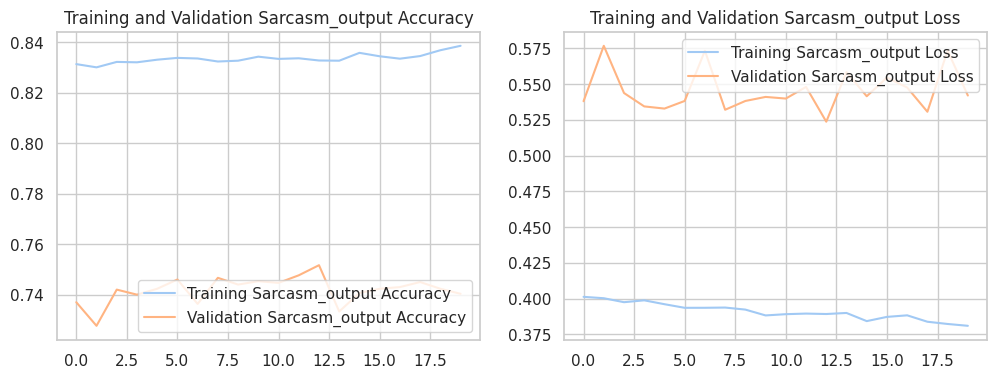

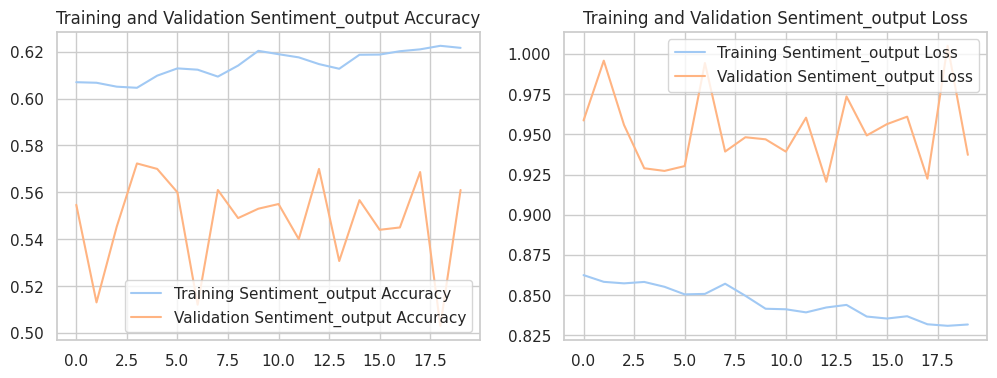

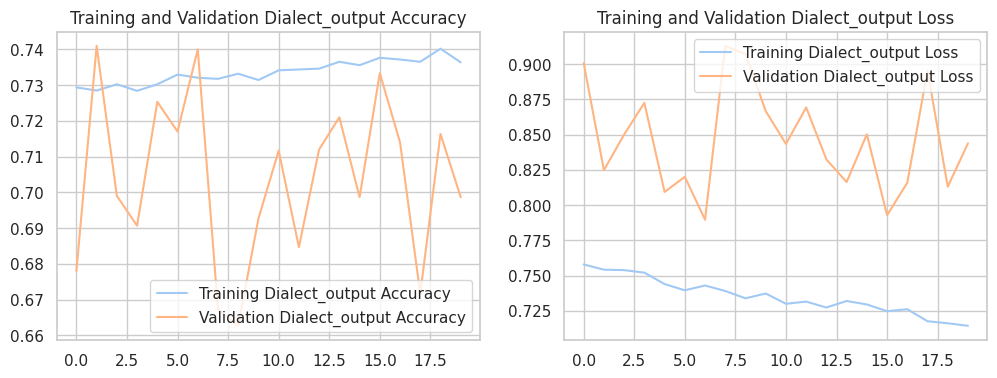

In [20]:
# ... existing code ...

import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# --- Training Parameters ---
epochs = 20 # Adjust as needed
batch_size = 64 # Adjust as needed

# Prepare target data as a dictionary matching the output layer names
y_train_dict = {
    'sarcasm_output': y_train_sarc,
    'sentiment_output': y_train_sent,
    'dialect_output': y_train_dial
}

# Prepare validation data (using the test set for simplicity)
# In practice, a separate validation split from the training data is recommended
y_test_dict = {
    'sarcasm_output': y_test_sarc,
    'sentiment_output': y_test_sent,
    'dialect_output': y_test_dial
}

# Optional: Add Early Stopping to prevent overfitting
# early_stopping = EarlyStopping(monitor='val_loss', # Monitor validation loss
#                                patience=3,        # Stop after 3 epochs with no improvement
#                                restore_best_weights=True) # Restore weights from the best epoch

print("Starting model training...")
# --- Train the Model ---
history = model_lstm.fit(
    X_train_pad,
    y_train_dict,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test_pad, y_test_dict),
    # callbacks=[early_stopping], # Uncomment to use early stopping
    verbose=1 # Set to 1 or 2 to see progress per epoch
)
print("Model training finished.")

# --- Evaluate the Model ---
print("\nEvaluating model on the test set...")
results = model_lstm.evaluate(X_test_pad, y_test_dict, batch_size=batch_size, verbose=1)

# Print evaluation results nicely
print("\n--- Test Set Evaluation Results ---")
# The results list contains: [total_loss, sarcasm_loss, sentiment_loss, dialect_loss, sarcasm_acc, sentiment_acc, dialect_acc]
# The order depends on the order of outputs in the Model definition and the metrics specified during compile
# Check model.metrics_names to be sure
print(f"Model Metrics Names: {model_lstm.metrics_names}")
for name, value in zip(model_lstm.metrics_names, results):
    print(f"{name}: {value:.4f}")

# --- Plot Training History (Optional) ---
def plot_history(history, metric_prefix):
    acc = history.history[f'{metric_prefix}_accuracy']
    val_acc = history.history[f'val_{metric_prefix}_accuracy']
    loss = history.history[f'{metric_prefix}_loss']
    val_loss = history.history[f'val_{metric_prefix}_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label=f'Training {metric_prefix.capitalize()} Accuracy')
    plt.plot(epochs_range, val_acc, label=f'Validation {metric_prefix.capitalize()} Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'Training and Validation {metric_prefix.capitalize()} Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label=f'Training {metric_prefix.capitalize()} Loss')
    plt.plot(epochs_range, val_loss, label=f'Validation {metric_prefix.capitalize()} Loss')
    plt.legend(loc='upper right')
    plt.title(f'Training and Validation {metric_prefix.capitalize()} Loss')
    plt.show()

# Plot for each task
plot_history(history, 'sarcasm_output')
plot_history(history, 'sentiment_output')
plot_history(history, 'dialect_output')


Generating predictions on the test set...
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step

--- Detailed Evaluation: Sarcasm ---
Confusion Matrix:


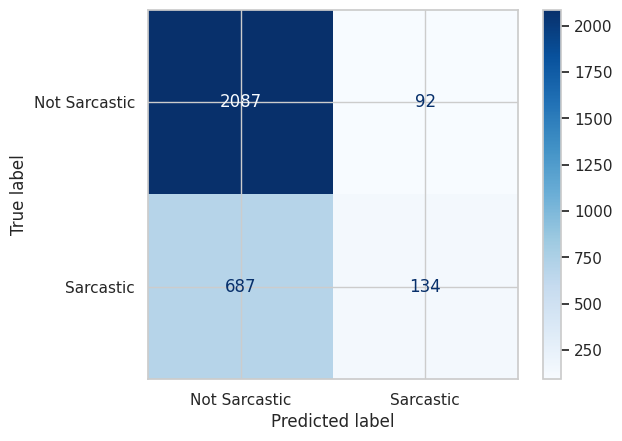


Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.75      0.96      0.84      2179
    Sarcastic       0.59      0.16      0.26       821

     accuracy                           0.74      3000
    macro avg       0.67      0.56      0.55      3000
 weighted avg       0.71      0.74      0.68      3000


--- Detailed Evaluation: Sentiment ---
Confusion Matrix:


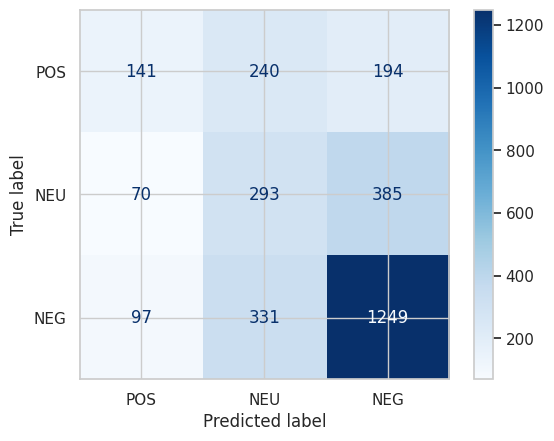


Classification Report:
              precision    recall  f1-score   support

         POS       0.46      0.25      0.32       575
         NEU       0.34      0.39      0.36       748
         NEG       0.68      0.74      0.71      1677

    accuracy                           0.56      3000
   macro avg       0.49      0.46      0.47      3000
weighted avg       0.55      0.56      0.55      3000


--- Detailed Evaluation: Dialect ---
Confusion Matrix:


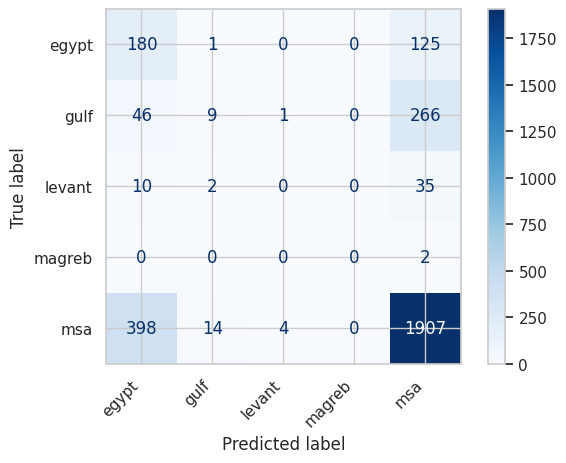


Classification Report:
              precision    recall  f1-score   support

       egypt       0.28      0.59      0.38       306
        gulf       0.35      0.03      0.05       322
      levant       0.00      0.00      0.00        47
      magreb       0.00      0.00      0.00         2
         msa       0.82      0.82      0.82      2323

    accuracy                           0.70      3000
   macro avg       0.29      0.29      0.25      3000
weighted avg       0.70      0.70      0.68      3000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
# ... existing code ...

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# --- Get Model Predictions ---
print("\nGenerating predictions on the test set...")
predictions = model_lstm.predict(X_test_pad, batch_size=batch_size)

# The output 'predictions' is a list containing the predictions for each output head
# predictions[0]: sarcasm_output (shape: [n_samples, 1])
# predictions[1]: sentiment_output (shape: [n_samples, 3])
# predictions[2]: dialect_output (shape: [n_samples, num_dialects])

# --- Process Predictions ---
# Sarcasm: Threshold probabilities at 0.5
y_pred_sarc = (predictions[0] > 0.5).astype(int).flatten()

# Sentiment: Get the index of the highest probability class
y_pred_sent = np.argmax(predictions[1], axis=1)

# Dialect: Get the index of the highest probability class
y_pred_dial = np.argmax(predictions[2], axis=1)

# --- Evaluate Each Task ---

print("\n--- Detailed Evaluation: Sarcasm ---")
print("Confusion Matrix:")
cm_sarc = confusion_matrix(y_test_sarc, y_pred_sarc)
disp_sarc = ConfusionMatrixDisplay(confusion_matrix=cm_sarc, display_labels=['Not Sarcastic', 'Sarcastic'])
disp_sarc.plot(cmap=plt.cm.Blues)
plt.show()
print("\nClassification Report:")
print(classification_report(y_test_sarc, y_pred_sarc, target_names=['Not Sarcastic', 'Sarcastic']))


print("\n--- Detailed Evaluation: Sentiment ---")
sentiment_labels = ['POS', 'NEU', 'NEG'] # Make sure this order matches your encoding {'POS': 0, 'NEU': 1, 'NEG': 2}
print("Confusion Matrix:")
cm_sent = confusion_matrix(y_test_sent, y_pred_sent)
disp_sent = ConfusionMatrixDisplay(confusion_matrix=cm_sent, display_labels=sentiment_labels)
disp_sent.plot(cmap=plt.cm.Blues)
plt.show()
print("\nClassification Report:")
print(classification_report(y_test_sent, y_pred_sent, target_names=sentiment_labels))


print("\n--- Detailed Evaluation: Dialect ---")
# Get dialect labels from the encoder used during preprocessing
dialect_labels = dialect_encoder.classes_
# Handle potential unseen labels (-1) if they weren't removed earlier
# Filter out test samples where the dialect was unseen during encoding fit
valid_dialect_indices = y_test_dial != -1
if not np.all(valid_dialect_indices):
    print(f"Note: Evaluating dialect task on {np.sum(valid_dialect_indices)} samples (excluding unseen dialects in test set).")
    y_test_dial_filtered = y_test_dial[valid_dialect_indices]
    y_pred_dial_filtered = y_pred_dial[valid_dialect_indices]
else:
    y_test_dial_filtered = y_test_dial
    y_pred_dial_filtered = y_pred_dial

print("Confusion Matrix:")
cm_dial = confusion_matrix(y_test_dial_filtered, y_pred_dial_filtered)
disp_dial = ConfusionMatrixDisplay(confusion_matrix=cm_dial, display_labels=dialect_labels)
disp_dial.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha='right') # Rotate labels for better visibility
plt.tight_layout() # Adjust layout
plt.show()
print("\nClassification Report:")
# Ensure target_names matches the labels used in the confusion matrix
print(classification_report(y_test_dial_filtered, y_pred_dial_filtered, target_names=dialect_labels))


#tf-idf + DNN

In [27]:

from sklearn.feature_extraction.text import TfidfVectorizer

# --- TF-IDF Vectorization ---
print("Starting TF-IDF Vectorization...")

# Initialize TF-IDF Vectorizer
# You can tune parameters like max_features, ngram_range, min_df, max_df
tfidf_vectorizer = TfidfVectorizer(max_features=10000, # Limit vocabulary size
                                   ngram_range=(1, 2), # Include unigrams and bigrams
                                   min_df=3)          # Ignore terms with frequency lower than 3

# Fit on training data and transform both train and test data
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['clean_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['clean_text'])

# Convert sparse matrix to dense for Keras input (can be memory intensive for large vocab/data)
# Alternatively, use models that handle sparse input or generators if memory is an issue.
# For typical DNNs in Keras, dense input is common.
X_train_tfidf_dense = X_train_tfidf.toarray()
X_test_tfidf_dense = X_test_tfidf.toarray()

# Get the number of features (vocabulary size)
num_tfidf_features = X_train_tfidf_dense.shape[1]
print(f"TF-IDF Vectorization complete. Number of features: {num_tfidf_features}")

# Verify shapes
print("Shape of X_train_tfidf_dense:", X_train_tfidf_dense.shape)
print("Shape of X_test_tfidf_dense:", X_test_tfidf_dense.shape)

# Target variables (y_train_dict, y_test_dict) are the same as prepared for the LSTM model
print("Using the same target variables (y_train_dict, y_test_dict) as before.")

Starting TF-IDF Vectorization...
TF-IDF Vectorization complete. Number of features: 10000
Shape of X_train_tfidf_dense: (12548, 10000)
Shape of X_test_tfidf_dense: (3000, 10000)
Using the same target variables (y_train_dict, y_test_dict) as before.


In [30]:
# ... existing code ...

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras import regularizers # Import if using L1/L2

# --- DNN Model Definition (with increased dropout) ---

# Input layer - shape matches the number of TF-IDF features
input_layer_dnn = Input(shape=(num_tfidf_features,), name='input_tfidf')

# Shared Dense layers
# Increased dropout rates
shared_dense = Dense(128, activation='relu', name='shared_dense_1')(input_layer_dnn)
shared_dense = Dropout(0.5, name='shared_dropout_1')(shared_dense) # Increased from 0.4
shared_dense = Dense(64, activation='relu', name='shared_dense_2')(shared_dense)
shared_dense = Dropout(0.4, name='shared_dropout_2')(shared_dense) # Increased from 0.3
# Optional: Add L2 regularization
# shared_dense = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001), name='shared_dense_1')(input_layer_dnn)
# ...

# --- Task-Specific Output Layers --- (remain the same)
sarcasm_output_dnn = Dense(1, activation='sigmoid', name='sarcasm_output')(shared_dense)
sentiment_output_dnn = Dense(3, activation='softmax', name='sentiment_output')(shared_dense)
dialect_output_dnn = Dense(num_dialects, activation='softmax', name='dialect_output')(shared_dense)


# --- Build the Model ---
model_dnn_regularized = Model(inputs=input_layer_dnn,
                              outputs=[sarcasm_output_dnn, sentiment_output_dnn, dialect_output_dnn],
                              name='MultiTask_TFIDF_DNN_Regularized') # New name

# --- Compile the Model ---
model_dnn_regularized.compile(optimizer=Adam(learning_rate=0.001),
                              loss=losses,
                              metrics=metrics)

# Print model summary
model_dnn_regularized.summary()

Model: "MultiTask_TFIDF_DNN_Regularized"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_tfidf         │ (None, 10000)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_dense_1      │ (None, 128)       │  1,280,128 │ input_tfidf[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_dropout_1    │ (None, 128)       │          0 │ shared_dense_1[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_dense_2      │ (None, 64)        │      8,256 │ shared_dropout_1… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_dropout_2    │ (None, 64)        │          0 │ shared_dense_2[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sarcasm_output      │ (None, 1)         │         65 │ shared_dropout_2… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sentiment_output    │ (None, 3)         │        195 │ shared_dropout_2… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dialect_output      │ (None, 5)         │        325 │ shared_dropout_2… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,288,969 (4.92 MB)

 Trainable params: 1,288,969 (4.92 MB)

 Non-trainable params: 0 (0.00 B)

Starting Regularized DNN model training with Early Stopping...
Epoch 1/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - dialect_output_accuracy: 0.6511 - dialect_output_loss: 1.1836 - loss: 2.7955 - sarcasm_output_accuracy: 0.7851 - sarcasm_output_loss: 0.5633 - sentiment_output_accuracy: 0.4551 - sentiment_output_loss: 1.0485 - val_dialect_output_accuracy: 0.7340 - val_dialect_output_loss: 0.8467 - val_loss: 2.4259 - val_sarcasm_output_accuracy: 0.7263 - val_sarcasm_output_loss: 0.5844 - val_sentiment_output_accuracy: 0.4963 - val_sentiment_output_loss: 0.9952
Epoch 2/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - dialect_output_accuracy: 0.7319 - dialect_output_loss: 0.7629 - loss: 1.9772 - sarcasm_output_accuracy: 0.8340 - sarcasm_output_loss: 0.3769 - sentiment_output_accuracy: 0.6315 - sentiment_output_loss: 0.8375 - val_dialect_output_accuracy: 0.7057 - val_dialect_output_loss: 0.8164 - val_loss: 2.3016 - val_sarcasm_output_accuracy: 0.7383 - val_sarcasm_output_loss: 0.5675 - val_s

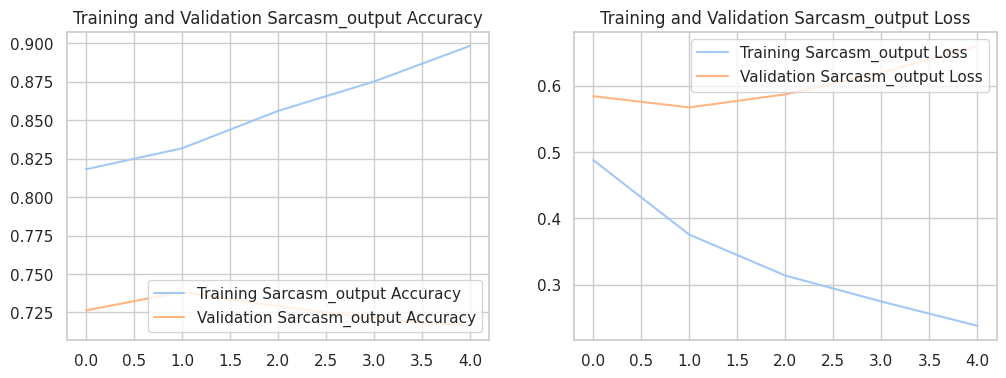

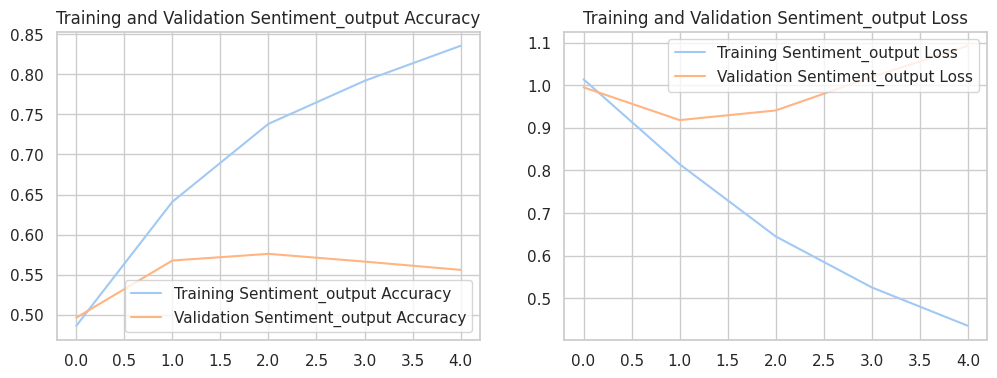

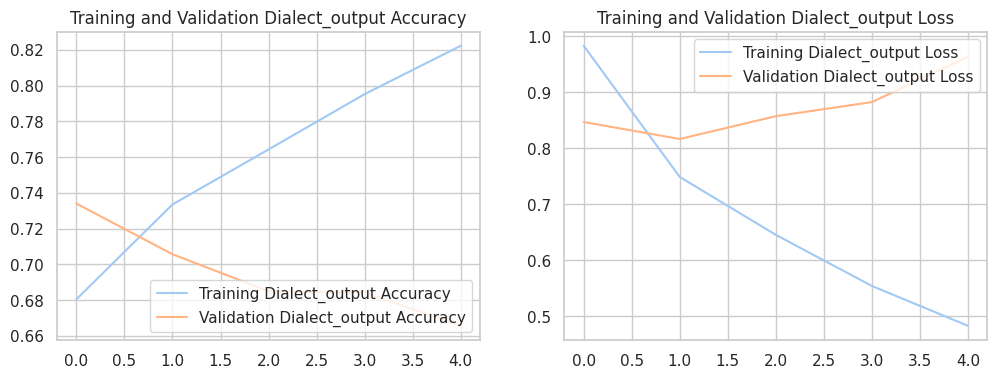

In [31]:
# ... existing code ...
from tensorflow.keras.callbacks import EarlyStopping # Make sure it's imported

# --- Training Parameters ---
epochs_dnn = 20 # Can increase epochs now, early stopping will handle it
batch_size_dnn = 64

# Target data (y_train_dict, y_test_dict) is already prepared

# Add Early Stopping
# Monitor 'val_loss' (overall validation loss)
# Patience: Number of epochs with no improvement after which training will be stopped.
# Restore_best_weights: Restore model weights from the epoch with the best value of the monitored quantity.
early_stopping_dnn = EarlyStopping(monitor='val_loss',
                                   patience=3, # Stop after 3 epochs of no improvement in val_loss
                                   restore_best_weights=True,
                                   verbose=1)

print("Starting Regularized DNN model training with Early Stopping...")
# --- Train the NEW Model ---
history_dnn_reg = model_dnn_regularized.fit( # Use the new model name
    X_train_tfidf_dense,
    y_train_dict,
    epochs=epochs_dnn,
    batch_size=batch_size_dnn,
    validation_data=(X_test_tfidf_dense, y_test_dict),
    callbacks=[early_stopping_dnn], # Add the callback here
    verbose=1
)
print("Regularized DNN model training finished.")

# --- Evaluate the NEW Model ---
print("\nEvaluating Regularized DNN model on the test set...")
# Use the new model name for evaluation
results_dnn_reg = model_dnn_regularized.evaluate(X_test_tfidf_dense, y_test_dict, batch_size=batch_size_dnn, verbose=1)

# Print evaluation results nicely
print("\n--- Regularized DNN Test Set Evaluation Results ---")
print(f"Model Metrics Names: {model_dnn_regularized.metrics_names}")
for name, value in zip(model_dnn_regularized.metrics_names, results_dnn_reg):
    print(f"{name}: {value:.4f}")

# --- Plot Training History (Optional) ---
print("\nPlotting Regularized DNN Training History...")
# Use the new history object
plot_history(history_dnn_reg, 'sarcasm_output')
plot_history(history_dnn_reg, 'sentiment_output')
plot_history(history_dnn_reg, 'dialect_output')

# --- IMPORTANT: Update subsequent cells ---
# Make sure the detailed evaluation (confusion matrix etc.) and prediction comparison cells
# now use the predictions from the new regularized model:
# predictions_dnn_reg = model_dnn_regularized.predict(...)
# y_pred_sarc_dnn_reg = ...
# etc.


Generating Regularized DNN predictions on the test set...
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

--- Detailed Regularized DNN Evaluation: Sarcasm ---
Confusion Matrix:


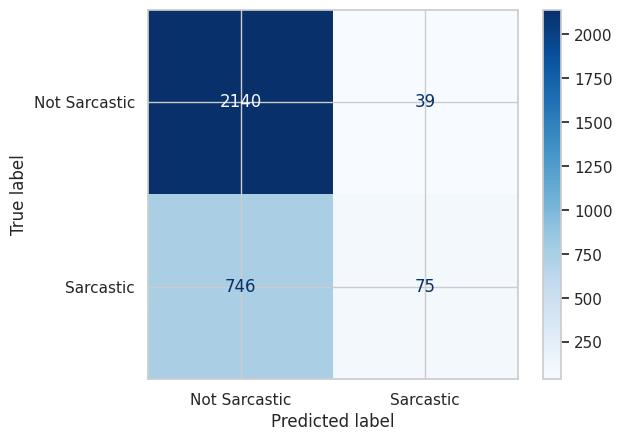


Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.74      0.98      0.85      2179
    Sarcastic       0.66      0.09      0.16       821

     accuracy                           0.74      3000
    macro avg       0.70      0.54      0.50      3000
 weighted avg       0.72      0.74      0.66      3000


--- Detailed Regularized DNN Evaluation: Sentiment ---
Confusion Matrix:


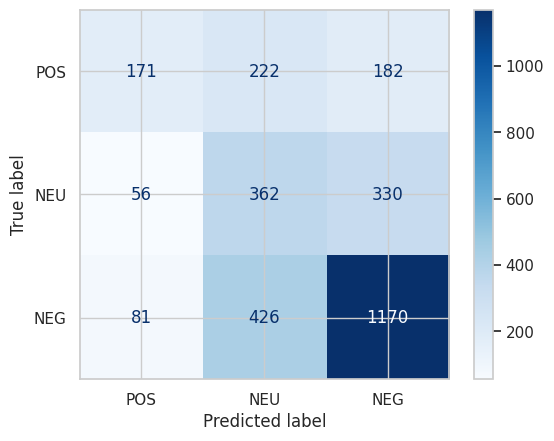


Classification Report:
              precision    recall  f1-score   support

         POS       0.56      0.30      0.39       575
         NEU       0.36      0.48      0.41       748
         NEG       0.70      0.70      0.70      1677

    accuracy                           0.57      3000
   macro avg       0.54      0.49      0.50      3000
weighted avg       0.58      0.57      0.57      3000


--- Detailed Regularized DNN Evaluation: Dialect ---
Confusion Matrix:


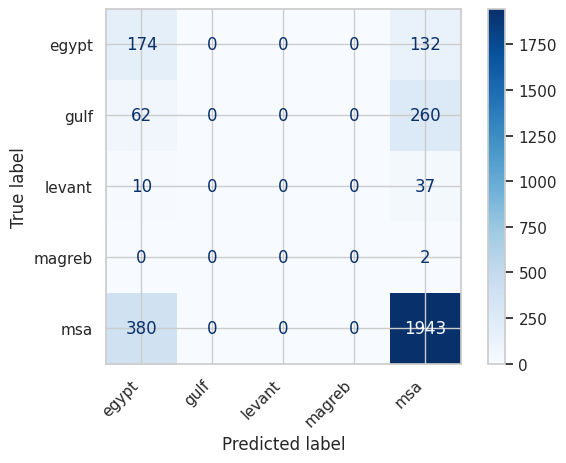


Classification Report:
              precision    recall  f1-score   support

       egypt       0.28      0.57      0.37       306
        gulf       0.00      0.00      0.00       322
      levant       0.00      0.00      0.00        47
      magreb       0.00      0.00      0.00         2
         msa       0.82      0.84      0.83      2323

    accuracy                           0.71      3000
   macro avg       0.22      0.28      0.24      3000
weighted avg       0.66      0.71      0.68      3000


--- Comparison of Ground Truth vs. Regularized DNN Predictions (15 samples) ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [33]:
# ... existing code ...

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# --- Get Regularized DNN Model Predictions ---
print("\nGenerating Regularized DNN predictions on the test set...")
# *** Use the regularized model ***
predictions_dnn_reg = model_dnn_regularized.predict(X_test_tfidf_dense, batch_size=batch_size_dnn)

# --- Process Regularized DNN Predictions ---
# *** Use predictions from the regularized model ***
y_pred_sarc_dnn_reg = (predictions_dnn_reg[0] > 0.5).astype(int).flatten()
y_pred_sent_dnn_reg = np.argmax(predictions_dnn_reg[1], axis=1)
y_pred_dial_dnn_reg = np.argmax(predictions_dnn_reg[2], axis=1)

# --- Evaluate Each Task (Regularized DNN) ---

print("\n--- Detailed Regularized DNN Evaluation: Sarcasm ---")
print("Confusion Matrix:")
# *** Use regularized predictions ***
cm_sarc_dnn_reg = confusion_matrix(y_test_sarc, y_pred_sarc_dnn_reg)
disp_sarc_dnn_reg = ConfusionMatrixDisplay(confusion_matrix=cm_sarc_dnn_reg, display_labels=['Not Sarcastic', 'Sarcastic'])
disp_sarc_dnn_reg.plot(cmap=plt.cm.Blues)
plt.show()
print("\nClassification Report:")
# *** Use regularized predictions ***
print(classification_report(y_test_sarc, y_pred_sarc_dnn_reg, target_names=['Not Sarcastic', 'Sarcastic']))


print("\n--- Detailed Regularized DNN Evaluation: Sentiment ---")
# sentiment_labels defined previously
print("Confusion Matrix:")
# *** Use regularized predictions ***
cm_sent_dnn_reg = confusion_matrix(y_test_sent, y_pred_sent_dnn_reg)
disp_sent_dnn_reg = ConfusionMatrixDisplay(confusion_matrix=cm_sent_dnn_reg, display_labels=sentiment_labels)
disp_sent_dnn_reg.plot(cmap=plt.cm.Blues)
plt.show()
print("\nClassification Report:")
# *** Use regularized predictions ***
print(classification_report(y_test_sent, y_pred_sent_dnn_reg, target_names=sentiment_labels))


print("\n--- Detailed Regularized DNN Evaluation: Dialect ---")
# dialect_labels defined previously
# Use the same filtering logic for unseen labels as before (valid_dialect_indices)
print("Confusion Matrix:")
# *** Use regularized predictions and filter ***
cm_dial_dnn_reg = confusion_matrix(y_test_dial_filtered, y_pred_dial_dnn_reg[valid_dialect_indices])
disp_dial_dnn_reg = ConfusionMatrixDisplay(confusion_matrix=cm_dial_dnn_reg, display_labels=dialect_labels)
disp_dial_dnn_reg.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print("\nClassification Report:")
# *** Use regularized predictions and filter ***
print(classification_report(y_test_dial_filtered, y_pred_dial_dnn_reg[valid_dialect_indices], target_names=dialect_labels))

num_samples_to_show = 15 # Or use the same value as for LSTM

# --- Also run the comparison cell using the regularized predictions ---
# (Code for comparison cell from Step 2.2.5, but using _reg variables)
# ...
print(f"\n--- Comparison of Ground Truth vs. Regularized DNN Predictions ({num_samples_to_show} samples) ---")
# Make sure this cell uses y_pred_sarc_dnn_reg, y_pred_sent_dnn_reg, y_pred_dial_dnn_reg
# comparison_dnn_reg_df = ...
# ...
# print(comparison_dnn_reg_df[display_columns])